 - Inputs:
 
     . preprocessed BOLD in MNI152Lin2009cAsym space (from previous step) as input BOLD scan
     
     . confounds file generated by fmriprep
     
     . MNI T1 + ROIs in "src/corr_data"

In [1]:
import os
import glob
import sys

#\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/
#####################################################################################
import SimpleITK as sitk
import nipype
import nipype.interfaces.io as nio   # Data i/oS
import nipype.pipeline.engine as pe  # pypeline engine
#from fsl.wrappers.melodic import fsl_regfilt # fsl_regfilt directly from fsl and not from nipype wrapper
import nipype.interfaces.fsl as fsl # numpy fsl
import nipype.interfaces.ants as ants
import nipype.interfaces.afni as afni
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, TraitedSpec, File, Directory
from nipype.interfaces.base import traits, isdefined, BaseInterface
from nipype.interfaces.utility import Merge, Split, Function, Rename, IdentityInterface

In [2]:
inBOLD='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/analysis/fmriprep/sub-02002/ses-01/func/sub-02002_ses-01_task-rest_space-MNI152NLin2009cAsym_desc-smoothAROMAnonaggr_bold.nii.gz'
inConf='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/analysis/fmriprep/sub-02002/ses-01/func/sub-02002_ses-01_task-rest_desc-confounds_regressors.tsv'
mniLabels='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/src/corr_data/dmn_thr3_4clustered_seedbased_correlation_2mm.nii.gz'
mniBrainMask='/Volumes/Clinical_Data/aghayoor/rsfMRI_share/src/corr_data/MNI152_T1_2mm_brain_mask.nii'
trimNum=10

In [3]:
####### Workflow ################################
WFname = 'rsfmriExt'
workflow = pe.Workflow(name=WFname, 
                       base_dir='/Users/aghayoor/Desktop/rsfmriExt')

# Setup any package specific configuration. The output file format for FSL routines is being set to compressed NIFTI.
fsl.FSLCommand.set_default_output_type('NIFTI')

# define input and output
inputsSpec = pe.Node(interface=IdentityInterface(fields=['inputBOLD', 
                                                        'inputConfoundsFile',
                                                        'inputMNILables',
                                                        'inputMNIBrainMask',
                                                        'trimNumber']), 
                     name='inputsSpec')

inputsSpec.inputs.inputBOLD = inBOLD
inputsSpec.inputs.inputConfoundsFile = inConf
inputsSpec.inputs.inputMNILables = mniLabels
inputsSpec.inputs.inputMNIBrainMask = mniBrainMask
inputsSpec.inputs.trimNumber = trimNum

outputsSpec = pe.Node(interface=IdentityInterface(fields=['out_file_bp',
                                                          'out_file_bp_mean',
                                                          'correlation_stats']),
                      name='outputsSpec')

### step 1: trim the input
def get_t_size(in_file, trimNum):
    from ants import image_header_info
    h = image_header_info(in_file)
    length = h['dimensions'][3]
    tsize = length - trimNum
    return int(tsize)

getTsize = pe.Node(interface=Function(function = get_t_size, 
                                       input_names=['in_file', 'trimNum'],
                                       output_names=['tsize']), 
                    name="get_t_size")
workflow.connect(inputsSpec, 'inputBOLD', getTsize, 'in_file')
workflow.connect(inputsSpec, 'trimNumber', getTsize, 'trimNum')

trim = pe.Node(interface=fsl.ExtractROI(), name='trim_bold')

trim.inputs.roi_file = 'bold_trimmed.nii'
workflow.connect(inputsSpec, 'inputBOLD', trim, 'in_file')
workflow.connect(inputsSpec, 'trimNumber', trim, 't_min')
workflow.connect(getTsize, 'tsize', trim, 't_size')

### step 2: run regression by fsl_regfilt

def trim_matrix(in_confound_file, trimNum):
    import os
    out_confound_file = os.path.realpath('trimmed_confound_matrix.tcv')
    with open(in_confound_file, 'r') as fin:
        data = fin.read().splitlines(True)
    with open(out_confound_file, 'w') as fout:
        fout.writelines(data[trimNum+1:])
    return out_confound_file

trimMatrix = pe.Node(interface=Function(function = trim_matrix, 
                                       input_names=['in_confound_file','trimNum'],
                                       output_names=['out_confound_file']), 
                    name="trim_confound_matrix")

workflow.connect(inputsSpec, 'trimNumber', trimMatrix, 'trimNum')
workflow.connect(inputsSpec, 'inputConfoundsFile', trimMatrix, 'in_confound_file')

# wrapper for fsl_regfilt
regression = pe.Node(interface=fsl.FilterRegressor(), name='regression')

regression.inputs.out_file = 'bold_trimmed_wmcsfreg.nii'
regression.inputs.filter_columns = [1,2,6]
workflow.connect(trim, 'roi_file', regression, 'in_file')
workflow.connect(trimMatrix, 'out_confound_file', regression, 'design_file')
workflow.connect(inputsSpec, 'inputMNIBrainMask', regression, 'mask')

### step 3: band pass filtering

def calculate_sigmas(in_file):
    def get_tr(in_file):
        from ants import image_header_info
        h = image_header_info(in_file)
        tr = h['spacing'][3]
        return tr

    tr = get_tr(in_file)
    f_hi = 0.01
    hp_sigma = 1/(2.0*f_hi*tr)
    f_lo = 0.1
    lp_sigma = 1/(4.0*f_lo*tr)
    out = str(lp_sigma) + ' ' + str(hp_sigma)
    return out

calcSigmas = pe.Node(interface=Function(function = calculate_sigmas, 
                                    input_names=['in_file'],
                                    output_names=['out']), 
                    name="calculate_hplp")

workflow.connect(inputsSpec, 'inputBOLD', calcSigmas, 'in_file')

## NOTE: As an alternative, you could also use "TemporalFilter" from fsl for bandpass filtering
bandpass = pe.Node(interface=fsl.ImageMaths(op_string='-bptf', suffix='_bptf'),
                name='bandpass')

bandpass.inputs.out_file = 'bold_trimmed_wmcsfreg_bp.nii'
workflow.connect(calcSigmas, 'out', bandpass, 'args')
workflow.connect(regression, 'out_file', bandpass, 'in_file')
workflow.connect(bandpass, 'out_file', outputsSpec, 'out_file_bp')

## Now take the mean for reference
mean = pe.Node(interface=fsl.ImageMaths(op_string='-Tmean', suffix='_mean'),
                name='mean')

mean.inputs.out_file = 'bold_trimmed_wmcsfreg_bp_mean.nii'
workflow.connect(bandpass, 'out_file', mean, 'in_file')
workflow.connect(mean, 'out_file', outputsSpec, 'out_file_bp_mean')

### step 4: correlation maps using afni
ncorr = pe.Node(interface=afni.NetCorr(), name='correlation')

ncorr.inputs.ts_out = True
ncorr.inputs.ts_label = True
ncorr.inputs.ts_wb_strlabel = True
ncorr.inputs.nifti = True
ncorr.inputs.ts_wb_corr = True
ncorr.inputs.ts_wb_Z = True
ncorr.inputs.fish_z = True
ncorr.inputs.out_file = 'sub0.tp1.ncorr'
#ncorr.inputs.out_file = os.path.realpath('sub.t.ncorr')
workflow.connect(bandpass, 'out_file', ncorr, 'in_file')
workflow.connect(inputsSpec, 'inputMNILables', ncorr, 'in_rois')
workflow.connect(inputsSpec, 'inputMNIBrainMask', ncorr, 'mask')
workflow.connect(ncorr, 'out_matrix', outputsSpec, 'correlation_stats')

workflow.write_graph("workflow_graph.dot")

201026-17:52:41,324 nipype.workflow INFO:
	 Generated workflow graph: /Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/workflow_graph.png (graph2use=hierarchical, simple_form=True).


'/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/workflow_graph.png'

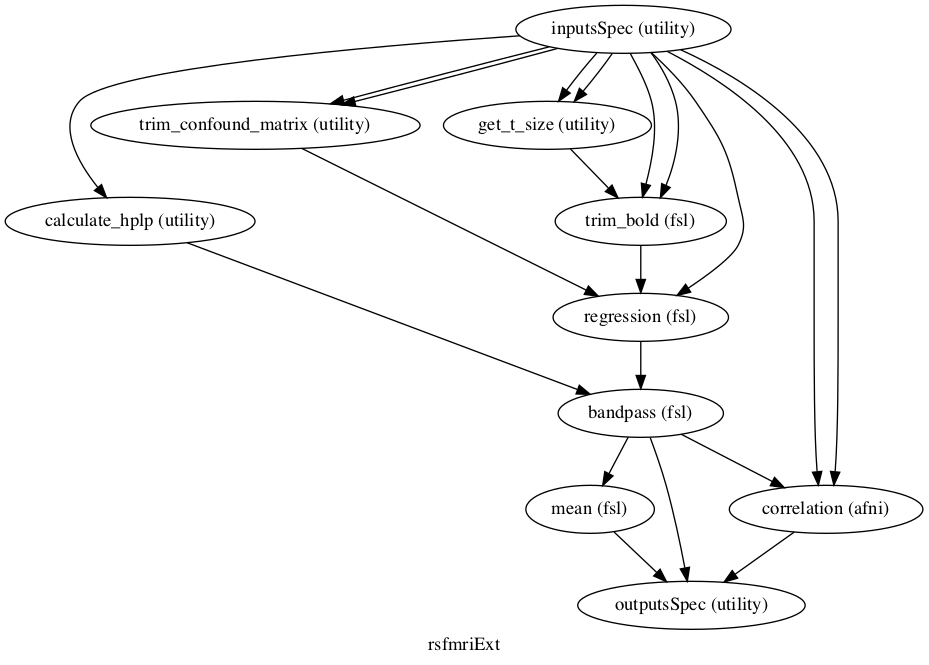

In [4]:
from IPython.display import Image
Image(filename="/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/workflow_graph.png")

In [5]:
workflow.config['execution'] = {'remove_unnecessary_outputs': 'False'}
workflow.run()

201026-17:52:41,377 nipype.workflow INFO:
	 Workflow rsfmriExt settings: ['check', 'execution', 'logging', 'monitoring']
201026-17:52:41,427 nipype.workflow INFO:
	 Running serially.
201026-17:52:41,428 nipype.workflow INFO:
	 [Node] Setting-up "rsfmriExt.calculate_hplp" in "/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/calculate_hplp".
201026-17:52:41,431 nipype.workflow INFO:
	 [Node] Cached "rsfmriExt.calculate_hplp" - collecting precomputed outputs
201026-17:52:41,432 nipype.workflow INFO:
	 [Node] "rsfmriExt.calculate_hplp" found cached.
201026-17:52:41,432 nipype.workflow INFO:
	 [Node] Setting-up "rsfmriExt.trim_confound_matrix" in "/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/trim_confound_matrix".
201026-17:52:41,444 nipype.workflow INFO:
	 [Node] Cached "rsfmriExt.trim_confound_matrix" - collecting precomputed outputs
201026-17:52:41,444 nipype.workflow INFO:
	 [Node] "rsfmriExt.trim_confound_matrix" found cached.
201026-17:52:41,445 nipype.workflow INFO:
	 [Node] Setting-up "rs

In [7]:
print(ncorr.result.out_matrix)

FileNotFoundError: /private/var/folders/sx/b3_y684n1v98257hsqd5yz5j7ncdbr/T/tmpi__z9vkv/rsfmriExt/correlation/result_correlation.pklz

In [ ]:
ncorr = afni.NetCorr()
ncorr.inputs.in_file = '/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/bandpass/bold_trimmed_wmcsfreg_bp.nii'
ncorr.inputs.mask = mniBrainMask
ncorr.inputs.in_rois = mniLabels
ncorr.inputs.ts_wb_corr = True
ncorr.inputs.ts_wb_Z = True
ncorr.inputs.fish_z = True
ncorr.inputs.nifti = True
ncorr.inputs.out_file = '/Users/aghayoor/Desktop/rsfmriExt/rsfmriExt/correlation/sub0.tp1.ncorr'
ncorr.cmdline # doctest: +SKIP

In [ ]:
res = ncorr.run()

In [ ]:
res.outputs

In [ ]:
# complete trim matrix (done)
# fix out name for band pass (done)
# fix dot for write graph (done)
# test wf (done)
# install afni (done)
# add afni module
# add netcorr to wf
# test wf

In [ ]:
# check current wf cmdlines (done)
# read how to add module (done)
# add new adni module
# add it to the workflow
# test wf
# add wf to a python file